In [1]:
# import packages
import os, sys, glob
import numpy as np
import skimage
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from importlib import reload
from DGXutils import GetFileNames

sys.path.append('../')

# custom
import utils.Metrics as Metrics
import utils.Preprocessing as Preprocessing

# Preprocessing

Processing: 490-ref-ISU_073-rep_1-W - JL.png (1/6)


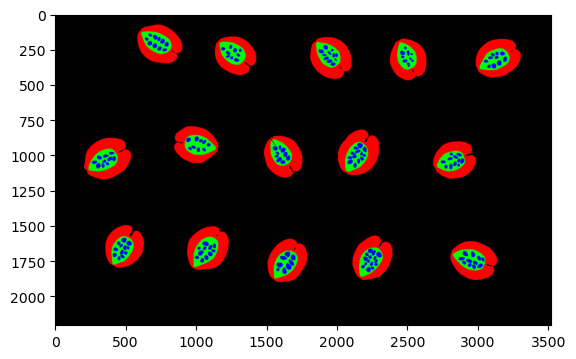

Processing: BILL_490-ref-ISU_073-rep_1-W.png (2/6)


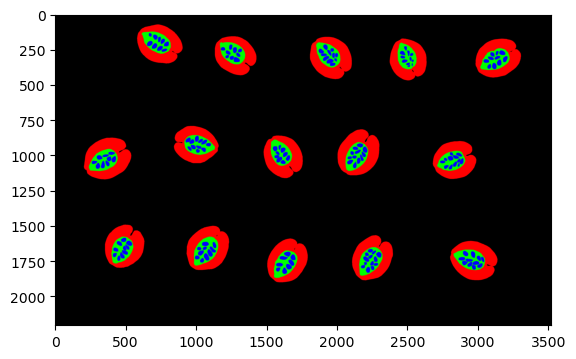

Processing: CRA_outline.png (3/6)


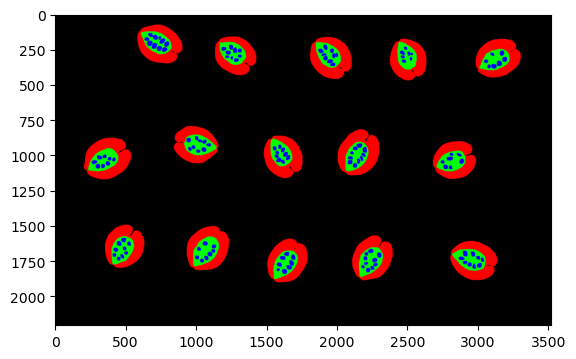

Processing: avg_pred.png (4/6)


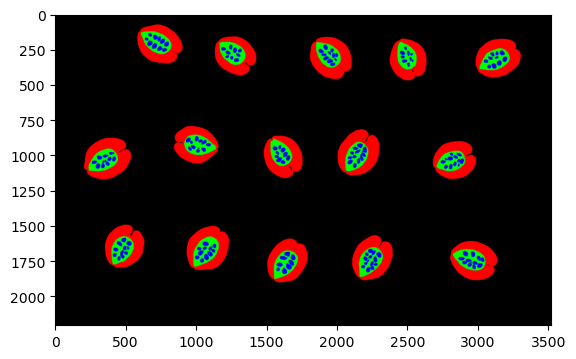

Processing: pete_490-ref-ISU_073-rep_1-W.png (5/6)


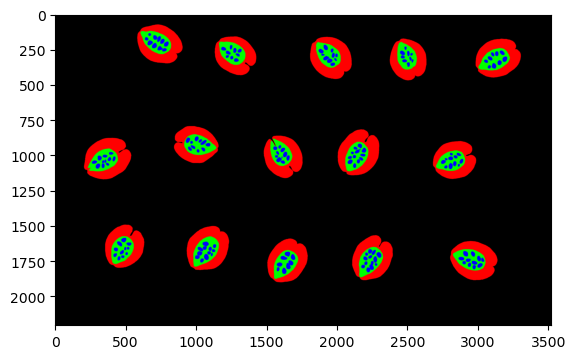

Processing: pred_490-ref-ISU_073-rep_1-W.png (6/6)


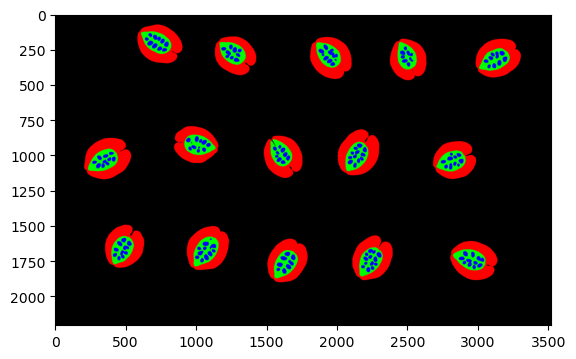

In [2]:
# load data + files
data_path = "../data/human_eval/"

# gather image names
image_names = GetFileNames(data_path, ".png")

# load images
images = []
for i, name in enumerate(image_names):
    print(f"Processing: {name} ({i+1}/{len(image_names)})")
    img = Image.open(data_path + name)
    img = np.array(img).astype("uint8") / 255

    # remove artifacts
    img = Preprocessing.remove_artifacts(img)

    img[img.sum(axis=2) == 3] = 0
    plt.imshow(img)
    plt.show()
    
    images.append(img)

# Split Images for Tukey Test

In [3]:
# get images, split by pod, and save
john, bill, roshan, avg, pete, model = images[0][:,:,:3], images[1][:,:,:3], images[2][:,:,:3], images[3], images[4], images[5]
avg = (((john + bill + roshan + pete) / 4.0) >= 0.5).astype(int)
avg = (avg * 255).astype("uint8")

# replace b + g px with b, g + r with g
avg[np.where(np.all(avg == [0, 255, 255], axis=-1))] = [0, 0, 255] 
avg[np.where(np.all(avg == [255, 255, 0], axis=-1))] = [0, 255, 0]

avg = Image.fromarray(avg)
avg.save(data_path + 'avg_pred.png')

In [4]:
# get image input names
john_in_name = ['490-ref-ISU_073-rep_1-W - JL.png',]
bill_in_name = ['BILL_490-ref-ISU_073-rep_1-W.png',]
roshan_in_name = ['CRA_outline.png',]
pete_in_name = ['pete_490-ref-ISU_073-rep_1-W.png',]
avg_in_name = ['avg_pred.png',]
model_in_name = ['pred_490-ref-ISU_073-rep_1-W.png',]

# define save path(s)
save_path = '../data/human_eval_by_pod/{}'

john_save_path = save_path.format('john/')
bill_save_path = save_path.format('bill/')
roshan_save_path = save_path.format('roshan/')
pete_save_path = save_path.format('pete/')
avg_save_path = save_path.format('avg/')
model_save_path = save_path.format('model/')

In [5]:
# john
Preprocessing.split_image(image_names = john_in_name,
                          image_path = data_path,
                          image_save_path = john_save_path,
                          mask_names = pete_in_name,
                          mask_path = data_path,
                          mask_save_path = john_save_path)

Processing image 1/2:  490-ref-ISU_073-rep_1-W - JL.png


  0%|          | 0/15 [00:00<?, ?it/s]

Image Splitting Complete!


In [6]:
# bill
Preprocessing.split_image(image_names = bill_in_name,
                          image_path = data_path,
                          image_save_path = bill_save_path,
                          mask_names = pete_in_name,
                          mask_path = data_path,
                          mask_save_path = bill_save_path)

Processing image 1/2:  BILL_490-ref-ISU_073-rep_1-W.png


  0%|          | 0/15 [00:00<?, ?it/s]

Image Splitting Complete!


In [7]:
# roshan
Preprocessing.split_image(image_names = roshan_in_name,
                          image_path = data_path,
                          image_save_path = roshan_save_path,
                          mask_names = pete_in_name,
                          mask_path = data_path,
                          mask_save_path = roshan_save_path)

Processing image 1/2:  CRA_outline.png


  0%|          | 0/15 [00:00<?, ?it/s]

Image Splitting Complete!


In [8]:
# pete
Preprocessing.split_image(image_names = pete_in_name,
                          image_path = data_path,
                          image_save_path = pete_save_path,
                          mask_names = pete_in_name,
                          mask_path = data_path,
                          mask_save_path = pete_save_path)

Processing image 1/2:  pete_490-ref-ISU_073-rep_1-W.png


  0%|          | 0/15 [00:00<?, ?it/s]

Image Splitting Complete!


In [9]:
# avg
Preprocessing.split_image(image_names = avg_in_name,
                          image_path = data_path,
                          image_save_path = avg_save_path,
                          mask_names = pete_in_name,
                          mask_path = data_path,
                          mask_save_path = avg_save_path)

Processing image 1/2:  avg_pred.png


  0%|          | 0/15 [00:00<?, ?it/s]

Image Splitting Complete!


In [10]:
# extract surfaces
john_wing = images[0][:,:,0] == 1
john_env = images[0][:,:,1] == 1
john_seed = images[0][:,:,2] == 1

bill_wing = (images[1][:,:,0] == 1)
bill_env = (images[1][:,:,1] == 1)
bill_seed = (images[1][:,:,2] == 1)

roshan_wing = images[2][:,:,0] == 1
roshan_env = images[2][:,:,1] == 1
roshan_seed = images[2][:,:,2] == 1

agg_avg_wing = images[3][:,:,0] == 1
agg_avg_env = images[3][:,:,1] == 1
agg_avg_seed = images[3][:,:,2] == 1

pete_wing = images[4][:,:,0] == 1
pete_env = images[4][:,:,1] == 1
pete_seed = images[4][:,:,2] == 1

model_wing = images[5][:,:,0] == 1
model_env = images[5][:,:,1] == 1
model_seed = images[5][:,:,2] == 1

# Comparison

In [11]:
# model v. gt (baseline)
model_wing_iou = Metrics.iou(model_wing, pete_wing)
model_env_iou = Metrics.iou(model_env, pete_env)
model_seed_iou = Metrics.iou(model_seed, pete_seed)

# print
print(f"Model/Pete Wing IOU: {model_wing_iou:.2%}")
print(f"Model/Pete Env IOU: {model_env_iou:.2%}")
print(f"Model/Pete Seed IOU: {model_seed_iou:.2%}")

Model/Pete Wing IOU: 96.71%
Model/Pete Env IOU: 83.94%
Model/Pete Seed IOU: 74.15%


In [12]:
# model v. bill
m_bill_wing_iou = Metrics.iou(model_wing, bill_wing)
m_bill_env_iou = Metrics.iou(model_env, bill_env)
m_bill_seed_iou = Metrics.iou(model_seed, bill_seed)

# print
print(f"Model/Bill Wing IOU: {m_bill_wing_iou:.2%}")
print(f"Model/Bill Env IOU: {m_bill_env_iou:.2%}")
print(f"Model/Bill Seed IOU: {m_bill_seed_iou:.2%}")

Model/Bill Wing IOU: 95.57%
Model/Bill Env IOU: 79.56%
Model/Bill Seed IOU: 73.82%


In [13]:
# model v. john
m_john_wing_iou = Metrics.iou(model_wing, john_wing)
m_john_env_iou = Metrics.iou(model_env, john_env)
m_john_seed_iou = Metrics.iou(model_seed, john_seed)

# print
print(f"Model/John Wing IOU: {m_john_wing_iou:.2%}")
print(f"Model/John Env IOU: {m_john_env_iou:.2%}")
print(f"Model/John Seed IOU: {m_john_seed_iou:.2%}")

Model/John Wing IOU: 94.26%
Model/John Env IOU: 83.83%
Model/John Seed IOU: 73.30%


In [14]:
# model v. roshan 
m_roshan_wing_iou = Metrics.iou(model_wing, roshan_wing)
m_roshan_env_iou = Metrics.iou(model_env, roshan_env)
m_roshan_seed_iou = Metrics.iou(model_seed, roshan_seed)

# print
print(f"Model/Roshan Wing IOU: {m_roshan_wing_iou:.2%}")
print(f"Model/Roshan Env IOU: {m_roshan_env_iou:.2%}")
print(f"Model/Roshan Seed IOU: {m_roshan_seed_iou:.2%}")

Model/Roshan Wing IOU: 95.81%
Model/Roshan Env IOU: 79.33%
Model/Roshan Seed IOU: 65.52%


In [15]:
# bill v. pete
bp_wing_iou = Metrics.iou(bill_wing, pete_wing)
bp_env_iou = Metrics.iou(bill_env, pete_env)
bp_seed_iou = Metrics.iou(bill_seed, pete_seed)

# print
print(f"Bill/Pete Wing IOU: {bp_wing_iou:.2%}")
print(f"Bill/Pete Env IOU: {bp_env_iou:.2%}")
print(f"Bill/Pete Seed IOU: {bp_seed_iou:.2%}")

Bill/Pete Wing IOU: 95.33%
Bill/Pete Env IOU: 75.53%
Bill/Pete Seed IOU: 66.97%


In [16]:
# bill v john
bj_wing_iou = Metrics.iou(bill_wing, john_wing)
bj_env_iou = Metrics.iou(bill_env, john_env)
bj_seed_iou = Metrics.iou(bill_seed, john_seed)

# print
print(f"Bill/John Wing IOU: {bj_wing_iou:.2%}")
print(f"Bill/John Env IOU: {bj_env_iou:.2%}")
print(f"Bill/John Seed IOU: {bj_seed_iou:.2%}")

Bill/John Wing IOU: 92.10%
Bill/John Env IOU: 79.95%
Bill/John Seed IOU: 66.35%


In [17]:
# bill v roshan
br_wing_iou = Metrics.iou(bill_wing, roshan_wing)
br_env_iou = Metrics.iou(bill_env, roshan_env)
br_seed_iou = Metrics.iou(bill_seed, roshan_seed)

# print
print(f"Bill/Roshan Wing IOU: {br_wing_iou:.2%}")
print(f"Bill/Roshan Env IOU: {br_env_iou:.2%}")
print(f"Bill/Roshan Seed IOU: {br_seed_iou:.2%}")

Bill/Roshan Wing IOU: 94.82%
Bill/Roshan Env IOU: 71.60%
Bill/Roshan Seed IOU: 61.70%


In [18]:
# john v. pete
pj_wing_iou = Metrics.iou(pete_wing, john_wing)
pj_env_iou = Metrics.iou(pete_env, john_env)
pj_seed_iou = Metrics.iou(pete_seed, john_seed)

# print
print(f"Pete/John Wing IOU: {pj_wing_iou:.2%}")
print(f"Pete/John Env IOU: {pj_env_iou:.2%}")
print(f"Pete/John Seed IOU: {pj_seed_iou:.2%}")

Pete/John Wing IOU: 92.81%
Pete/John Env IOU: 80.30%
Pete/John Seed IOU: 69.70%


In [19]:
# john v. roshan
rj_wing_iou = Metrics.iou(roshan_wing, john_wing)
rj_env_iou = Metrics.iou(roshan_env, john_env)
rj_seed_iou = Metrics.iou(roshan_seed, john_seed)

# print
print(f"Roshan/John Wing IOU: {rj_wing_iou:.2%}")
print(f"Roshan/John Env IOU: {rj_env_iou:.2%}")
print(f"Roshan/John Seed IOU: {rj_seed_iou:.2%}")

Roshan/John Wing IOU: 91.77%
Roshan/John Env IOU: 74.85%
Roshan/John Seed IOU: 58.60%


In [20]:
# pete v. roshan
pr_wing_iou = Metrics.iou(pete_wing, roshan_wing)
pr_env_iou = Metrics.iou(pete_env, roshan_env)
pr_seed_iou = Metrics.iou(pete_seed, roshan_seed)

# print
print(f"Pete/Roshan Wing IOU: {pr_wing_iou:.2%}")
print(f"Pete/Roshan Env IOU: {pr_env_iou:.2%}")
print(f"Pete/Roshan Seed IOU: {pr_seed_iou:.2%}")

Pete/Roshan Wing IOU: 96.26%
Pete/Roshan Env IOU: 78.15%
Pete/Roshan Seed IOU: 60.72%


In [21]:
# actual average of model v human seg
avg_wing = (model_wing_iou + m_bill_wing_iou + m_john_wing_iou + m_roshan_wing_iou) / 4.0
avg_env = (model_env_iou + m_bill_env_iou + m_john_env_iou + m_roshan_env_iou) / 4.0
avg_seed = (model_seed_iou + m_bill_seed_iou + m_john_seed_iou + m_roshan_seed_iou) / 4.0

print(f"Average Model v. Human Wing IoU: {avg_wing:.2%}")
print(f"Average Model v. Human Env IoU: {avg_env:.2%}")
print(f"Average Model v. Human Seed IoU: {avg_seed:.2%}")

Average Model v. Human Wing IoU: 95.59%
Average Model v. Human Env IoU: 81.66%
Average Model v. Human Seed IoU: 71.70%


In [22]:
human_wing = (bp_wing_iou + bj_wing_iou + pj_wing_iou + br_wing_iou + pr_wing_iou + rj_wing_iou) / 6.0
human_env = (bp_env_iou + bj_env_iou + pj_env_iou + br_env_iou + pr_env_iou + rj_env_iou) / 6.0
human_seed = (bp_seed_iou + bj_seed_iou + pj_seed_iou + br_seed_iou + pr_seed_iou + rj_seed_iou) / 6.0

print(f"Average Human v. Human Wing IoU: {human_wing:.2%}")
print(f"Average Human v. Human Env IoU: {human_env:.2%}")
print(f"Average Human v. Human Seed IoU: {human_seed:.2%}")

Average Human v. Human Wing IoU: 93.85%
Average Human v. Human Env IoU: 76.73%
Average Human v. Human Seed IoU: 64.01%


In [23]:
# compare in- to out-of-distribution performance
human_v_roshan_w = (br_wing_iou + pr_wing_iou + rj_wing_iou) / 3.0
human_v_roshan_e = (br_env_iou + pr_env_iou + rj_env_iou) / 3.0
human_v_roshan_s = (br_seed_iou + pr_seed_iou + rj_seed_iou) / 3.0

print(f"Human v. Roshan Wing IoU: {human_wing:.2%}")
print(f"Human v. Roshan Env IoU: {human_env:.2%}")
print(f"Human v. Roshan Seed IoU: {human_seed:.2%}")
print("--------------------------------")
print(f"Model v. Roshan Wing IOU: {m_roshan_wing_iou:.2%}")
print(f"Model v. Roshan Env IOU: {m_roshan_env_iou:.2%}")
print(f"Model v. Roshan Seed IOU: {m_roshan_seed_iou:.2%}")

Human v. Roshan Wing IoU: 93.85%
Human v. Roshan Env IoU: 76.73%
Human v. Roshan Seed IoU: 64.01%
--------------------------------
Model v. Roshan Wing IOU: 95.81%
Model v. Roshan Env IOU: 79.33%
Model v. Roshan Seed IOU: 65.52%


# Alternative Avg. Calculation 

In [24]:
# test alternative average calculation
avg_human_wing = ((bill_wing.astype(int) + john_wing.astype(int) + pete_wing.astype(int) + roshan_wing.astype(int)) / 4.0)
avg_human_env = ((bill_env.astype(int) + john_env.astype(int) + pete_env.astype(int) + roshan_env.astype(int)) / 4.0)
avg_human_seed = ((bill_seed.astype(int) + john_seed.astype(int) + pete_seed.astype(int) + roshan_seed.astype(int)) / 4.0)

In [25]:
# use saved image for calc
avgavg_wing = Metrics.iou(model_wing, agg_avg_wing)
avgavg_env = Metrics.iou(model_env, agg_avg_env)
avgavg_seed = Metrics.iou(model_seed, agg_avg_seed)

print(f"Avg. Model v. Avg. Human Wing IoU: {avgavg_wing:.2%}")
print(f"Avg. Model v. Avg. Human Env IoU: {avgavg_env:.2%}")
print(f"Avg. Model v. Avg. Human Seed IoU: {avgavg_seed:.2%}")

Avg. Model v. Avg. Human Wing IoU: 96.89%
Avg. Model v. Avg. Human Env IoU: 86.88%
Avg. Model v. Avg. Human Seed IoU: 80.58%


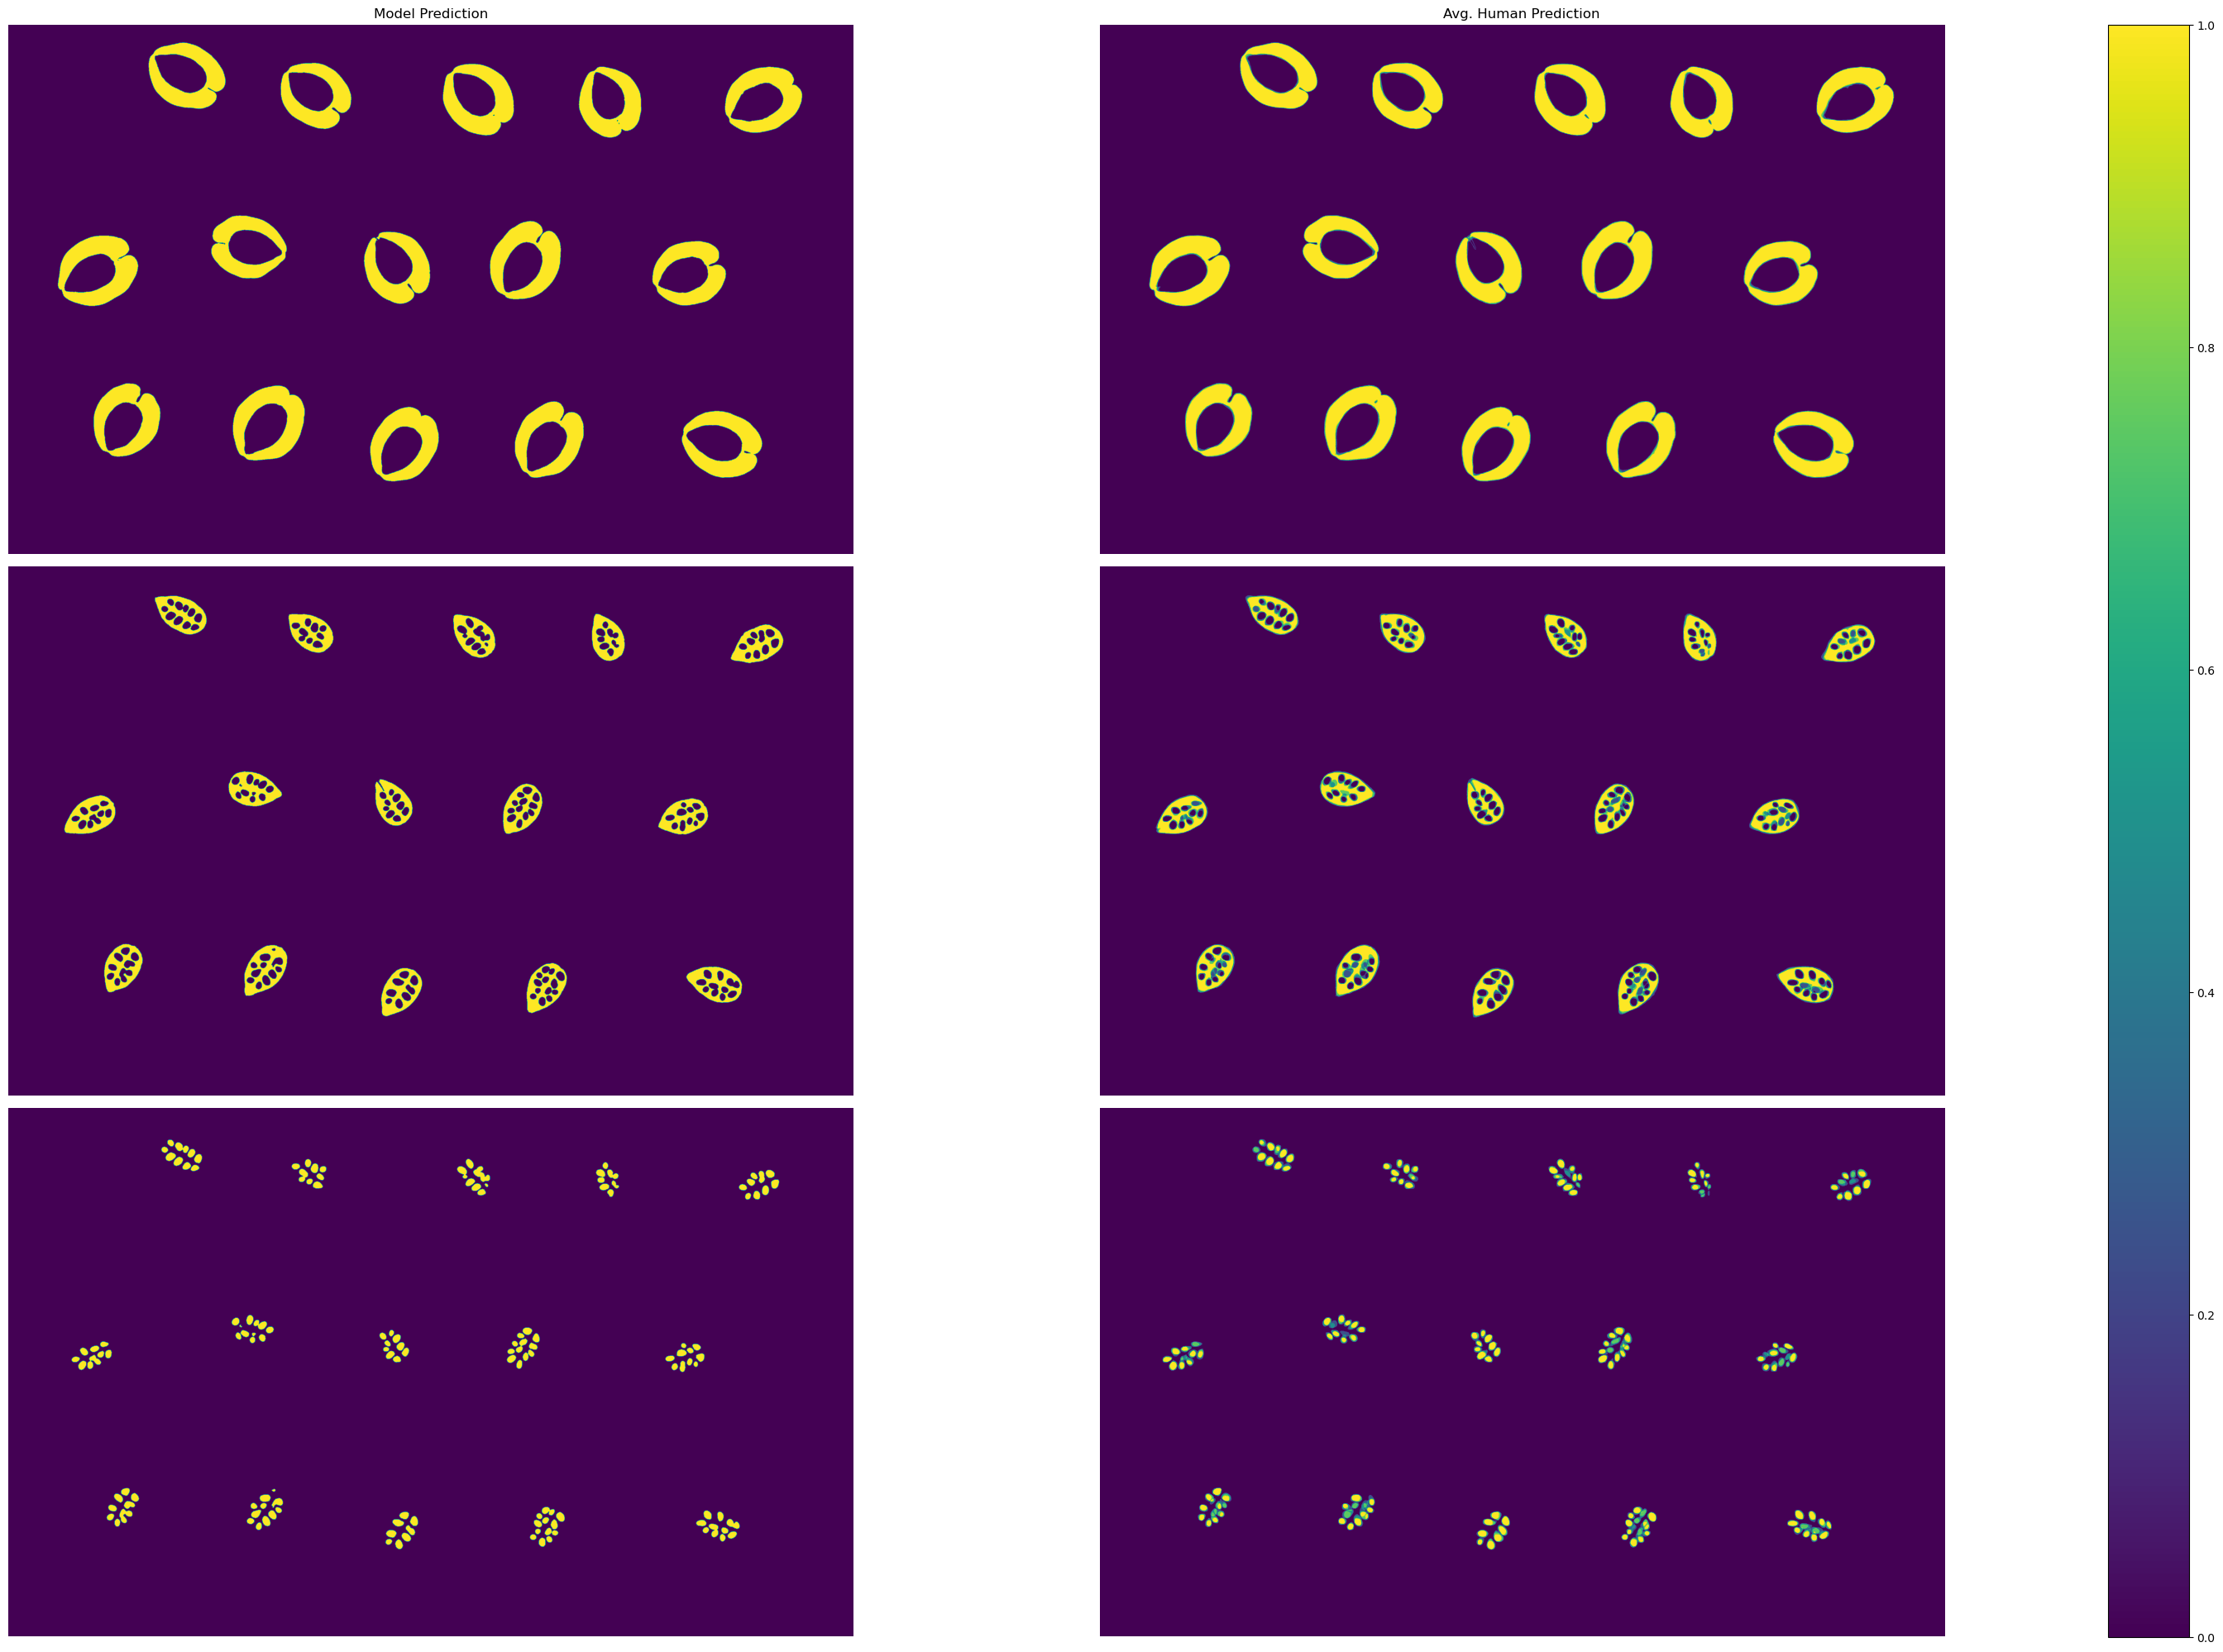

In [26]:
fig, ax = plt.subplots(3, 2, figsize=(40,20))

# wing
im = ax[0,0].imshow(model_wing)
im = ax[0,1].imshow(avg_human_wing)
ax[0,0].set_axis_off()
ax[0,1].set_axis_off()
ax[0,0].set_title("Model Prediction")
ax[0,1].set_title("Avg. Human Prediction")

# env
im = ax[1,0].imshow(model_env)
im = ax[1,1].imshow(avg_human_env)
ax[1,0].set_axis_off()
ax[1,1].set_axis_off()

# seed
im = ax[2,0].imshow(model_seed)
im = ax[2,1].imshow(avg_human_seed)
ax[2,0].set_axis_off()
ax[2,1].set_axis_off()

fig.tight_layout()

cax, kw = mpl.colorbar.make_axes([ax for ax in ax.flat])
plt.colorbar(im, cax=cax, **kw)
plt.show()

In [27]:
avg_human_wing = avg_human_wing > 0.5
avg_human_env = avg_human_env > 0.5
avg_human_seed = avg_human_seed > 0.5

# Plot

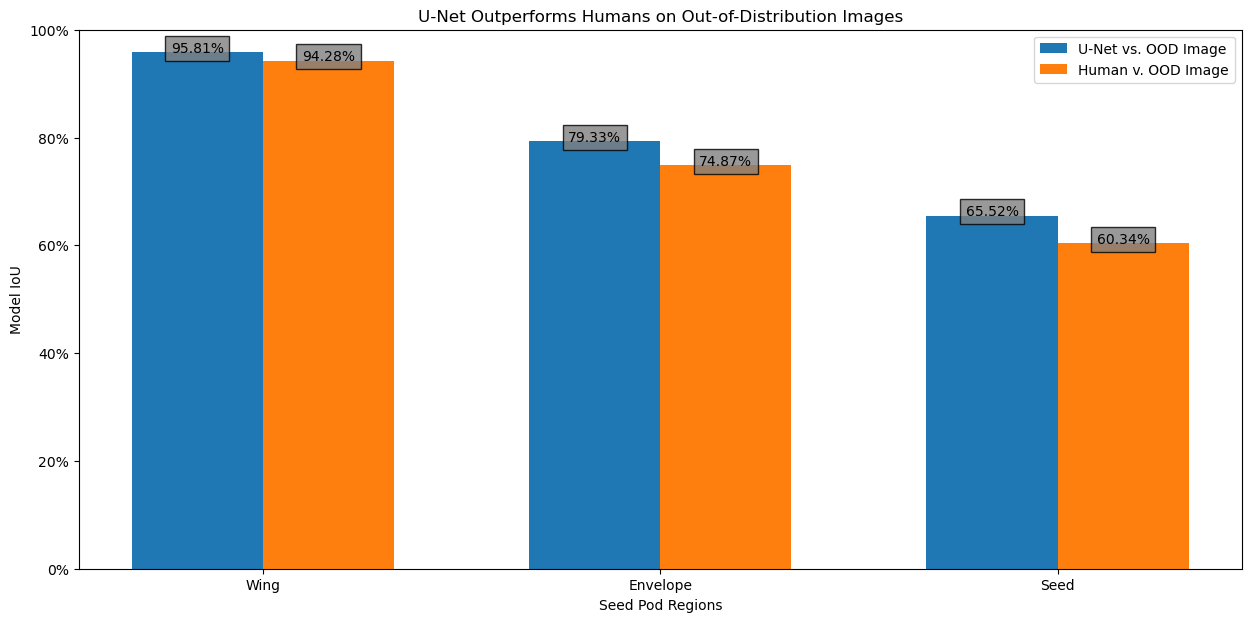

In [28]:
# plot human / model performance against roshan

# function for labels
def addlabels_doublebar(labels):
    for i in range(0, len(labels), 2):

        # add first label bar
        plt.text(i/2, labels[i], f'{labels[i]:.2%}', ha="center",
                 bbox = dict(facecolor="gray", alpha=.8))
        
        # add second label bar
        plt.text(width + i/2, labels[i+1], f'{labels[i+1]:.2%}', ha="center",
                 bbox = dict(facecolor="gray", alpha=.8))
        
# number of pairs, position, and width
N = 3
ind = np.arange(N)
width = round(1/N, 2)

# model/human v. roshan values
model_roshan = (m_roshan_wing_iou, m_roshan_env_iou, m_roshan_seed_iou)
human_roshan = (human_v_roshan_w, human_v_roshan_e, human_v_roshan_s)

labels = []
for pair in zip(model_roshan, human_roshan):
    labels.extend(pair)

# position of bars on x-axis
ind = np.arange(N)

# plot
plt.figure(figsize=(15,7))
plt.bar(ind, model_roshan, width, label="U-Net vs. OOD Image")
plt.bar(ind+width, human_roshan, width, label="Human v. OOD Image")

plt.xlabel("Seed Pod Regions")
plt.ylabel("Model IoU")
plt.title("U-Net Outperforms Humans on Out-of-Distribution Images")

# tick marks
plt.xticks(ind + width / 2, ('Wing', 'Envelope', 'Seed'))
plt.gca().set_ylim(0, 1)
plt.gca().yaxis.set_major_formatter('{x:.0%}')

# add labels
addlabels_doublebar(labels)

# legend
plt.legend(loc='best')
plt.show()

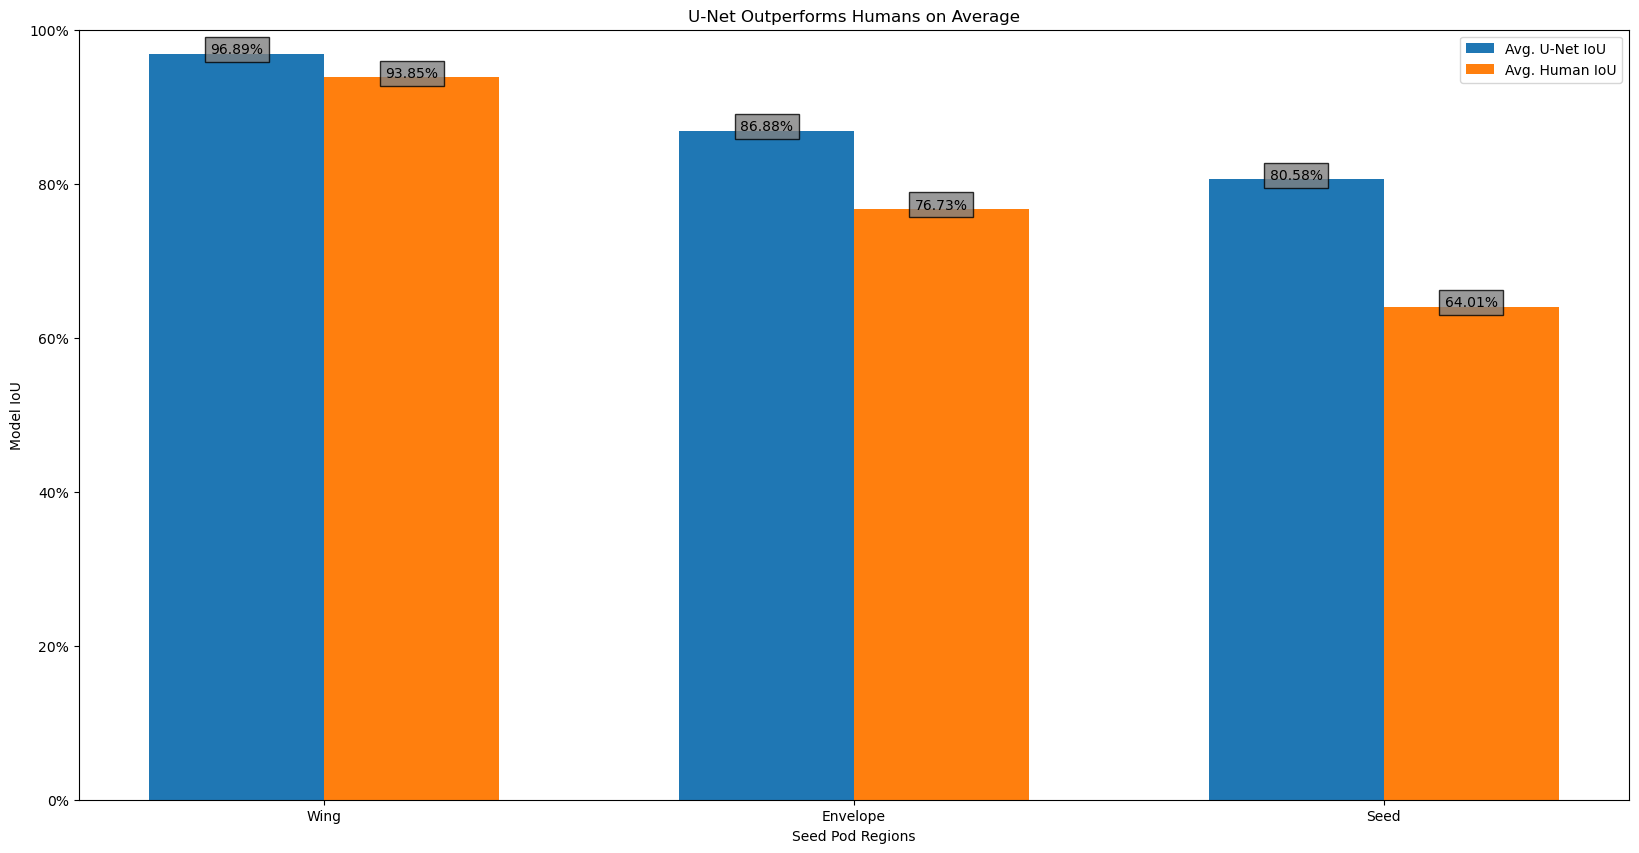

In [29]:
# plot avg model performance vs. avg human performance
# plot human / model performance against roshan

# function for labels
def addlabels_doublebar(labels):
    for i in range(0, len(labels), 2):

        # add first label bar
        plt.text(i/2, labels[i], f'{labels[i]:.2%}', ha="center",
                 bbox = dict(facecolor="gray", alpha=.8))
        
        # add second label bar
        plt.text(width + i/2, labels[i+1], f'{labels[i+1]:.2%}', ha="center",
                 bbox = dict(facecolor="gray", alpha=.8))
        
# number of pairs, position, and width
N = 3
ind = np.arange(N)
width = round(1/N, 2)

# model/human v. roshan values
model = (avgavg_wing, avgavg_env, avgavg_seed)
human = (human_wing, human_env, human_seed)

labels = []
for pair in zip(model, human):
    labels.extend(pair)

# position of bars on x-axis
ind = np.arange(N)

# plot
plt.figure(figsize=(20,10))
plt.bar(ind, model, width, label="Avg. U-Net IoU")
plt.bar(ind+width, human, width, label="Avg. Human IoU")

plt.xlabel("Seed Pod Regions")
plt.ylabel("Model IoU")
plt.title("U-Net Outperforms Humans on Average")

# tick marks
plt.xticks(ind + width / 2, ('Wing', 'Envelope', 'Seed'))
plt.gca().set_ylim(0, 1)
plt.gca().yaxis.set_major_formatter('{x:.0%}')

# add labels
addlabels_doublebar(labels)

# legend
plt.legend(loc='best')
plt.show()